# Entanglement in the dark

Author: Eugene Dumitrescu, based on Lecture 3 Dicke state notebook


In this notebook we (loosely) follow the prescription of Ref[1] to simulate the dynamical entanglement of QD systems coupled to an environment. To begin with we take the simplest environment: a single mode cavity. In later iterations this environment will be modified to reflect the a quantum plasmonic reservoir.  

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from qutip import *

#
# particle specific operators
#
def sx(i, N, M):
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def pu(i,q):
    """up state population for ith qubit
    q = 0: |0> population 
    q = 1: |1> population
    """
    return (I(N,M) + (-1)**q * sz(i,N,M)) * 0.5


def a(N, M):
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def I(N,M):
    """Identity operator on full Hilbert space"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i):
    """ dipole operator for ith spin """
    return sp(i, N, M) + sm(i, N, M)


## Introduction:

Our Hamiltonian models a pair of two levels systems which interact with a single cavity mode
<center>
$\displaystyle H = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger) + \Omega (a + a^\dagger)$
</center>


The interaction is sometimes defined in terms of the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$ but we have applied the rotating wave approximation and the last term represents the classical driving of the plasmon mode.  


## Hamiltonian:

Below is the static Hamiltonian which may include a ${constant}$ driving term

In [16]:
N = 2          # Number of spin 1/2's
M = 5          # Number of cavity modes

# cavity occupation number and dipole operators
n_a = a(N,M).dag() * a(N,M)
d_a = a(N,M).dag() + a(N,M)

wc = 1.0         # cavity frequency
w0 = 1.00        # emitter spacing
g  = 0.01        # emitter-cavity coupling
gs = [0.01,0.02] # position dependent couplings
da = 0.0         # constant non-time dependent driving 

# define Hamiltonian
H_0 = wc * n_a + w0 * sum(sp(i,N,M) * sm(i,N,M)  for i in range(N))
H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
H_DRV = da * d_a + da * d(1)
H2 = H_0 - H_RWA - H_DRV

# Initial state
psi_0 = basis(2,1) # qb 1  ground state
psi_1 = basis(2,0) # qb 2 excited state
psi_c = basis(M,0) # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)

In [ ]:
def HR(c):
    return H_0 - c * H_RWA
def HI(c):
    return H_0 - c * H_INT - H_DRV

gs = np.linspace(0,.5,num = 100) # coupling constant range

A = np.array([HR(z).eigenenergies() for z in gs])
A = A.transpose()
for i in range(N*M):
    plt.plot(gs, A[i], '.')
plt.show()

A = np.array([HI(z).eigenenergies() for z in gs])
A = A.transpose()
for i in range(N*M):
    plt.plot(gs, A[i], '.')
plt.show()

# Dynamical Evolution

Let us initialize system with one dot excited and the other in the ground state and allow the system to evolve dissipatively. Short lived entanglement, as measured by the concurrence, should be generated between the dots; although asymmetric couplings may be needed to realize the expected result. 


## Master Eqaution:

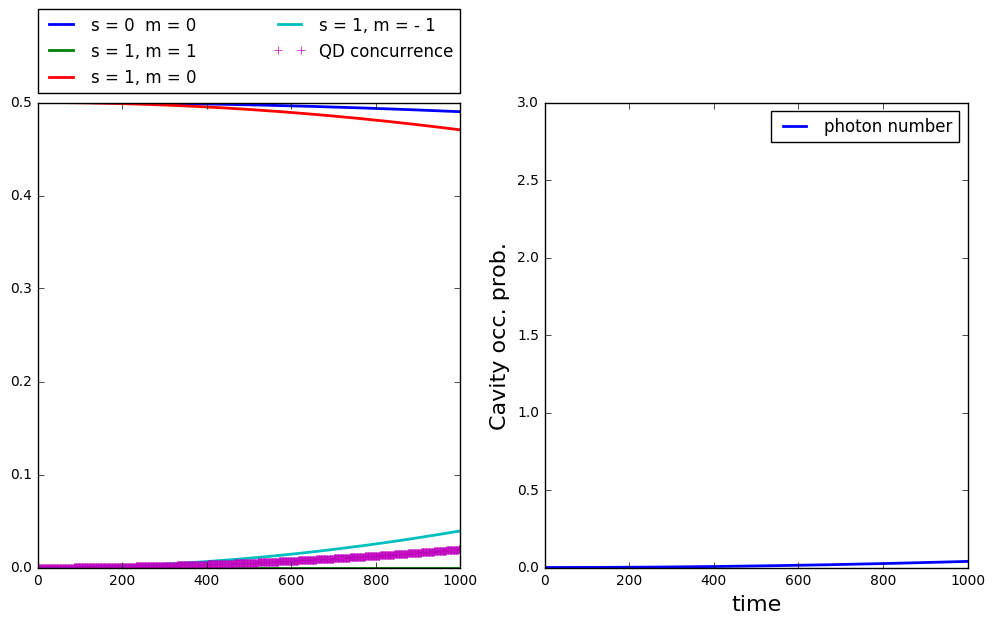

In [14]:
# Master equation dissipation parameters
kappa = 0 * wc/5e2      # cavity dissipation rate
gamma = 0 * wc/1e3      # atomic dissipation rate
n_th  = 0.0         # thermal cavity occupation number 

# add cavity then qubit collapse operators
c_ops = [np.sqrt(kappa * (n_th + 1)) * a(N,M), np.sqrt(kappa * n_th) * a(N,M).dag()] 
for i in range(2):
    rate = np.sqrt(gamma * (1 + n_th))
    if rate > 0.0:
        c_ops.append(rate * sm(i,N,M))        # relaxation
    rate = gamma * n_th
    if rate > 0.0:
        c_ops.append(rate * sm(i,N,M).dag())  # excitation
        
# discretized time domain
# t_f = 5 / kappa     # final time
# d_t = t_f / 10      # time steps
# tlist = np.linspace(0, t_f, d_t)
tlist = np.linspace(0, 1000, 1000)


# run dynamics solver
result = mesolve(H2, psi_tot, tlist, c_ops, [])

# symmetric (s = 1 triplet) and antisymmetric (s = 0 singlet) subspace projectors
P_S = .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))
P_A = .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))
# s = 0, m_l = \pm 1 (pp/mm) triplet projectors
P_pp = np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])
P_mm = np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])

# calculate expectation values
Ex_P_S = [expect(P_S,st) for st in result.states]
Ex_P_A = [expect(P_A,st) for st in result.states]
Ex_Ppp = [expect(P_pp,st) for st in result.states]
Ex_Pmm = [expect(P_mm,st) for st in result.states]
Ex_n_a = [expect(n_a,st) for st in result.states]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

#plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].plot(tlist, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0")
axes[0].plot(tlist, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(tlist, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0")
axes[0].plot(tlist, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(tlist, concr , '+', linewidth=2, label="QD concurrence")
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(tlist, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, 3)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()

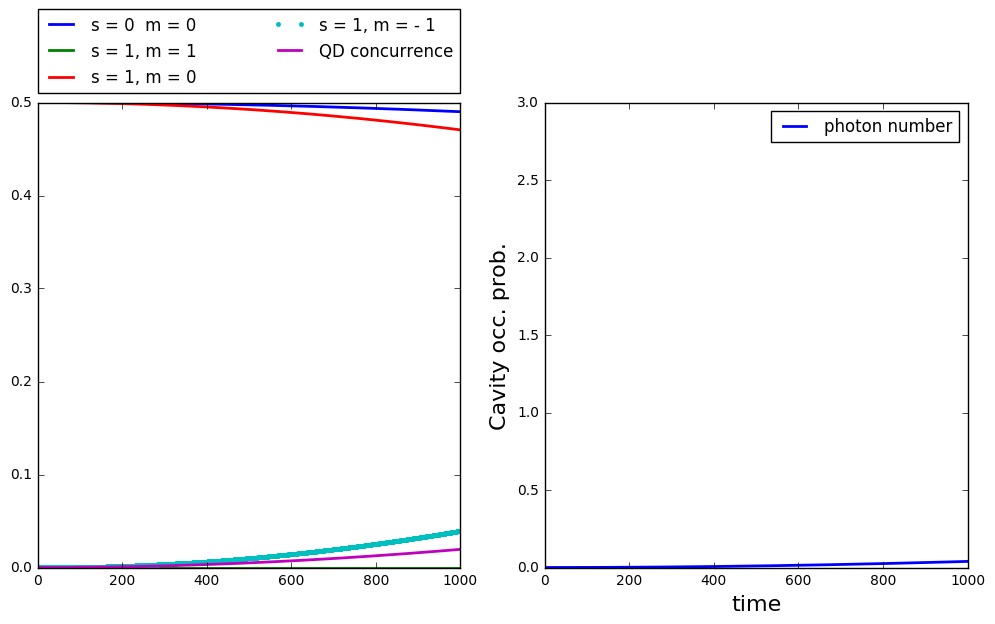

In [15]:
#plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].plot(tlist, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0")
axes[0].plot(tlist, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(tlist, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0")
axes[0].plot(tlist, Ex_Pmm, '.', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(tlist, concr , '-', linewidth=2, label="QD concurrence")
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(tlist, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, 3)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()

# With classical periodic driving field 

In [98]:
N = 2          # Number of spin 1/2's
M = 5          # Number of cavity modes

# cavity occupation number and dipole operators
n_a = a(N,M).dag() * a(N,M)
d_a = a(N,M).dag() + a(N,M)

wc = 1.0       # cavity frequency
w0 = 1.00      # emitter spacing
g  = 0.01      # emitter-cavity coupling
dspp = 0.000   # plsmon mode dipole moment -- driving coupling strength
dem1 = 0.001   # emitter # 1 dipole moment -- driving coupling strength
dem2 = 0.0     # emitter # 2 dipole moment -- driving coupling strength
wd = 1.00      # driving frequency

# define Hamiltonian
H_0 = wc * n_a + w0 * sum(sp(i,N,M) * sm(i,N,M)  for i in range(N))
H_RWA = sum(a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M) for i in range(N))
H_DVR = dspp * d_a + dem1 * d(0)
H_TOT = [H_0 - g * H_INT, [-H_DVR, 'sin(wd * t)']]

# Initial state
psi_0 = basis(2,1) # qb 1  ground state
psi_1 = basis(2,1) # qb 2 excited state
psi_c = basis(M,0) # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)

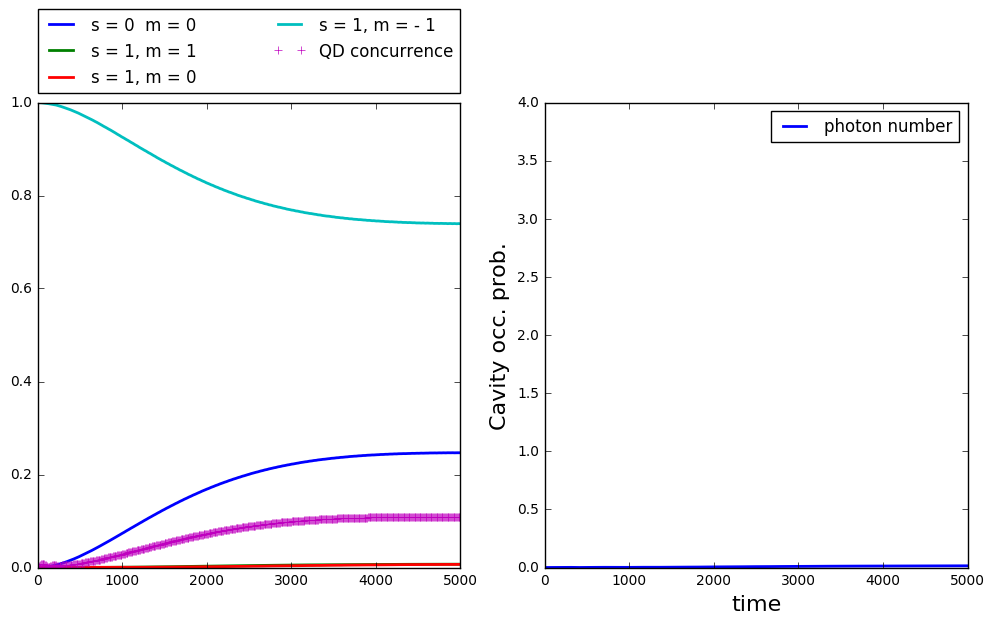

In [99]:
# Master equation dissipation parameters
kappa = wc/5e2      # cavity dissipation rate
gamma = wc/1e3      # atomic dissipation rate
n_th  = 0.0         # thermal cavity occupation number 

# cavity and qubit collapse operators
c_ops = [np.sqrt(kappa * (n_th + 1)) * a(N,M), np.sqrt(kappa * n_th) * a(N,M).dag()] 
for i in range(2):
    rate = np.sqrt(gamma * (1 + n_th))
    if rate > 0.0:
        c_ops.append(rate * sm(i,N,M))        # relaxation
    rate = gamma * n_th
    if rate > 0.0:
        c_ops.append(rate * sm(i,N,M).dag())  # excitation

# discretized time domain
t_f = 10 / kappa    # final time
d_t = t_f / 10      # time steps
tlist = np.linspace(0, t_f, d_t)

# time dependent arguments        
args = {'wd': wd}

# run dynamics solver
result = mesolve(H_TOT, psi_tot, tlist, c_ops, [], args)

# symmetric (s = 1 triplet) and antisymmetric (s = 0 singlet) subspace projectors
P_S = .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))
P_A = .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))
# s = 0, m_l = \pm 1 triplet projectors
P_pp = np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])
P_mm = np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])

# calculate expectation values of above operators
Ex_P_S = [expect(P_S,st) for st in result.states]
Ex_P_A = [expect(P_A,st) for st in result.states]
Ex_Ppp = [expect(P_pp,st) for st in result.states]
Ex_Pmm = [expect(P_mm,st) for st in result.states]
Ex_n_a = [expect(n_a,st) for st in result.states]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].plot(tlist, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0")
axes[0].plot(tlist, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(tlist, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0")
axes[0].plot(tlist, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(tlist, concr , '+', linewidth=2, label="QD concurrence")
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(tlist, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, 4)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)

plt.show()

# Correlations

We proposed to optically characterize the entanglement generated in our device by means of the normalized second order coherence function:

<center>
$\displaystyle g^2(r_1,t_1;r_2,t_2) = \frac{\langle a^\dagger (r_1,t_1) a^\dagger (r_2,t_2) a(r_2,t_2) a(r_1,t_1) \rangle}{\langle a^\dagger(r_1,t_1) a(r_1,t_1) \rangle \langle a^\dagger(r_2,t_2) a(r_2,t_2) \rangle}$
</center>

Suppose we probe light from the same spatio-temporal source (i.e. a stationary process with $r_1=r_2$) and introduce a time delay denoted by $\tau = t_2 - t_1$. In this case $g^2$ does not depend on $t_1$ and $t_1$ but only on their difference $\tau$. We can then express the second order coherence function in the following form:

<center>
$\displaystyle g^2(t, \tau) = \frac{\langle a^\dagger (t) a^\dagger (t + \tau) a(t + \tau) a(t) \rangle}{\langle a^\dagger(t) a(t) \rangle^2}$
</center>

Below we show 2 coherence functions. In the first $t$ is set to $0$ such that $g^2(0,\tau)\equiv g^2(\tau)$ and correlations are therefore calculated with respect to the initial (Fock state) of the cavity. One may also calculate the correlation function in the limit $t \rightarrow \infty$ such that the correlations are calculated with respect to the steady state solution (provided such a solution exists).